In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
import torch
import torch.nn.functional as F
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [4]:
data = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv").reset_index(drop=True)
Y = data["label"].to_numpy()
X = data.drop("label", axis=1).to_numpy()
X = X.reshape(-1, 1, 28, 28)

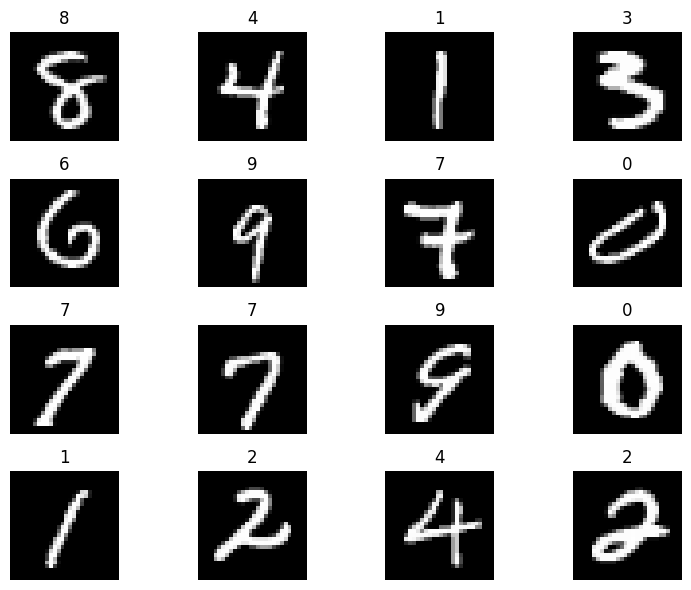

In [5]:
dimension = 4
ints = np.random.randint(0, X.shape[0], dimension**2, dtype=int)
fig, axes = plt.subplots(dimension, dimension, figsize=(8, 6))
axes = axes.ravel()
for i in range(dimension**2):
    axes[i].imshow(X[ints[i], 0, :, :], cmap='gray')  
    axes[i].set_title(Y[ints[i]])
    axes[i].axis('off')  

plt.tight_layout()
plt.show()

In [67]:
class CNN():
    def __init__(self, X, Y):
        new = np.zeros((10, Y.shape[0]))
        new[Y, range(Y.shape[0])] = 1
        self.X = X     
        self.Y = new
        self.filters = []
        self.alpha, self.beta = [], []
        self.W = []
        self.B = []
        self.activation = []
        
    def create_mini_batch(self, size = 64):
        indices = np.random.choice(self.X.shape[0], size=size, replace=False)
        self.X_B = self.X[indices]
        self.Y_B = self.Y[:, indices]
    
    def create_filter_layer(self, filter_dims = (5, 1, 3, 3)):
        if not self.filters:
            if self.X_B.shape[1] != filter_dims[1]:
                raise Exception("The filter dimensions do not match")
            he_number = np.sqrt(2 / np.prod(filter_dims[1:]))
            self.filters.append(np.random.randn(*filter_dims) * he_number) 
        else:
            if self.filters[-1].shape[0] != filter_dims[1]:
                raise Exception("The filter dimensions do not match")
            he_number = np.sqrt(2 / np.prod(filter_dims[1:]))
            self.filters.append(np.random.randn(*filter_dims) * he_number)
            
    def calculate_input_size(self):
        if self.filters:
            starting_dims = self.X_B.shape[2]
            for i in self.filters:
                starting_dims -= i.shape[2]
                starting_dims += 1
            return starting_dims**2 * i.shape[0]
        else:
            raise Exception("There are no filters")
            
        
    def padding(self,Z, padding =2):
        return np.pad(Z, pad_width=((0,0), (0,0), (padding,padding), (padding,padding)))
        
    def fully_connected_layer(self, layer_depth=10, activation="ReLU"):
        if not self.W:
            he_number = np.sqrt(2/ self.calculate_input_size())
            self.W.append(np.random.randn(layer_depth, self.calculate_input_size()) *he_number)
            self.B.append(np.random.randn(layer_depth, 1))
            self.alpha.append(np.ones((layer_depth, 1)))
            self.beta.append(np.zeros((layer_depth, 1)))
            self.activation.append(activation)
        else:
            he_number = np.sqrt(2/ self.W[-1].shape[0])
            self.W.append(np.random.randn(layer_depth, self.W[-1].shape[0]) *he_number)
            self.B.append(np.random.randn(layer_depth, 1))
            self.alpha.append(np.ones((layer_depth, 1)))
            self.beta.append(np.zeros((layer_depth, 1)))
            self.activation.append(activation)
    def convolution(self,Z, f):
        N, C, H, W = Z.shape
        NS, CS, HS, WS = Z.strides
        C_out, _, f_K, f_K = f.shape
        C_outs, _, _, FWS = f.strides
        f = np.ascontiguousarray(as_strided(f, shape=(C*f_K**2, C_out), strides=(FWS, C_outs)))
        inner_dims = f_K * f_K * C
        A = as_strided(Z, shape=(N, H-f_K+1, W-f_K+1, C, f_K, f_K)
                      , strides = (NS, HS, WS, CS, HS, WS)).reshape(-1, inner_dims)
        out = A @ f
        S, E = out.strides
        out = as_strided(out, shape=(N, C_out, (H-f_K+1)*(W-f_K+1)), strides=(E*(W-f_K+1)*(H-f_K+1)*C_out, E, S )).reshape(N, C_out, H-f_K+1, W-f_K+1)
        return out
    def convolution_backward(self,Z, dZ, f):
        N, _, H, H = dZ.shape
        dNs, dCs, dHs, dHs = dZ.strides
        N, C_in , _, _= Z.shape
        NS, CS, HS, WS = Z.strides
        C_out, f_C_in, f_K, f_K = f.shape
        inner_dims = H * H * N
        dZ = as_strided(dZ, shape = (C_out, N, H**2), strides=(dCs, dNs ,dHs)).reshape(C_out, inner_dims)
        Z = as_strided(Z, shape=(C_in, f_K, f_K,N, H, H), strides=(CS, HS, WS, NS, HS, WS)).reshape(-1,inner_dims).T
        out =  dZ @ Z 
        return out.reshape(f.shape)
    def convolution_backward_Z(self, dZ, f):
        dZ = self.padding(dZ)
        N, C, H, W = dZ.shape
        NS, CS, HS, WS = dZ.strides
        f = np.rot90(f, k=2, axes=(2, 3))
        _, f_C_in, f_K, f_K = f.shape
        C_outs, _, _, FWS = f.strides
        inner_dims = f_K * f_K
        f = f.reshape(C, f_C_in, f_K**2)
        dZ = as_strided(dZ, shape=(C, N, H-2, W-2,f_K, f_K), strides=(CS, NS, HS, WS, HS, WS)).reshape(C, -1 , inner_dims)
        out = np.zeros((N, f_C_in, H-2, W-2))
        for c in range(C):
            out += (dZ[c] @ f[c].T).reshape(N, f_C_in, H-2, W-2)
        return  out.reshape(N, f_C_in, H-2, W-2)
    def batch_norm(self, Z):
        mean = np.mean(Z, axis=1, keepdims=True)
        var = np.var(Z, axis=1, keepdims=True)
        out = (Z - mean) / np.sqrt(var+1e-8)
        return out, mean, var
    def batch_norm_backward(self,Z, PB, alpha, mean, var, dZ):
        dalpha = np.sum(dZ * PB, axis=1, keepdims=True)
        dbeta = np.sum(dZ, axis=1, keepdims = True)
        dPB = dZ * alpha
        dvar = np.sum(dPB * (Z - mean) * ( (-1/2) * (var+1e-8)**(-3/2) ), axis=1, keepdims=True)
        dmean = np.sum(dPB * (-1/np.sqrt(var + 1e-8) ), axis=1, keepdims=True) + dvar * (np.sum(-2*(Z - mean), axis=1, keepdims=True)/Z.shape[1])
        dZ = dPB * (1/np.sqrt(var + 1e-8)) + dvar * ((2*(Z - mean)/Z.shape[1])) + dmean / Z.shape[1]
        return dZ, dalpha, dbeta
    def activations(self,Z, activation):
        if activation == "ReLU":
            return Z * (Z > 0)
        if activation == "softmax":
            return np.exp(Z - np.max(Z, axis=0, keepdims=True) + 1e-8) / np.sum(np.exp(Z - np.max(Z, axis=0, keepdims=True)+ 1e-8), axis = 0, keepdims = True)
    def calculate_loss(self,Z):
        self.loss = -np.mean(np.sum(np.log(Z + 1e-8) * self.Y_B, axis=0))
    def forward(self):
        self.Z_filter = [0 for i in range(len(self.filters))]
        self.A_filter = [0 for i in range(len(self.filters))]
        self.Z = [0 for i in range(len(self.W))]
        self.PB = [0 for i in range(len(self.W))]
        self.A = [0 for i in range(len(self.W))]
        self.Z_filter[0] = self.convolution(self.X_B, self.filters[0])
        self.A_filter[0] = self.Z_filter[0] * (self.Z_filter[0] > 0)
        self.mean, self.var = [0 for i in range(len(self.W))], [0 for i in range(len(self.W))]
        for i in range(1, len(self.filters)):
            self.Z_filter[i] = self.convolution(self.Z_filter[i-1], self.filters[i])
            self.A_filter[i] = self.Z_filter[i] * (self.Z_filter[i] > 0)
        self.Z[0] = self.W[0] @ self.Z_filter[i].reshape(self.calculate_input_size(), -1)
        self.PB[0], self.mean[0], self.var[0] = self.batch_norm(self.Z[0])
        self.A[0] = self.PB[0] * self.alpha[0] + self.beta[0]
        self.A[0] = self.activations(self.A[0], self.activation[0])
        for i in range(1,len(self.W)):
            self.Z[i] = self.W[i] @ self.Z[i-1]
            self.PB[i], self.mean[i], self.var[i] = self.batch_norm(self.Z[i])
            self.A[i] = self.PB[i] * self.alpha[i] + self.beta[i]
            self.A[i] = self.activations(self.A[i], self.activation[i])
        self.calculate_loss(self.A[-1])

    def backward(self):
        num = len(self.W) - 1
        self.dW, self.dB, self.dfilter = [0 for i in range(len(self.W))], [0 for i in range(len(self.W))], [0 for i in range(len(self.filters))]
        self.dalpha, self.dbeta = [0 for i in range(len(self.W))], [0 for i in range(len(self.W))]
        dZ = (self.A[num] - self.Y_B) / self.Y_B.shape[0]
        dZ, self.dalpha[num], self.dbeta[num] = self.batch_norm_backward(self.Z[num], self.PB[num], self.alpha[num], self.mean[num], self.var[num], dZ)
        self.dW[num] = dZ @ self.A[num-1].T
        self.dB[num] = np.sum(dZ, axis=1, keepdims=True)
        dZ = self.W[num].T @ dZ * (self.Z[num-1] > 0)
        for i in range(num-1, 0, -1):
            dZ, self.dalpha[i], self.dbeta[i] = self.batch_norm_backward(self.Z[i], self.PB[i], self.alpha[i], self.mean[i], self.var[i], dZ) 
            self.dW[i] = dZ @ self.A[i-1].T
            self.dB[i] = np.sum(dZ, axis=1, keepdims=True)
            dZ = self.W[i].T @ dZ * (1 * (self.Z[i-1] > 0))
        dZ, self.dalpha[0], self.dbeta[0] = self.batch_norm_backward(self.Z[0], self.PB[0], self.alpha[0], self.mean[0], self.var[0], dZ)
        self.dW[0] = dZ @ self.Z_filter[-1].reshape(self.calculate_input_size(), -1).T
        dZ = (self.W[0].T @ dZ).reshape(self.Z_filter[-1].shape) * (self.Z_filter[-1] > 0)
        for i in range(len(self.filters) -1, 0, -1):
            self.dfilter[i] = self.convolution_backward(self.A_filter[i-1], dZ, self.filters[i])
            dZ = self.convolution_backward_Z(dZ, self.filters[i]) * (self.Z_filter[i-1] > 0)
        self.dfilter[0] = self.convolution_backward(self.X_B, dZ, self.filters[0])

    def update(self, learning_rate=0.01):
        for i in range(len(self.filters)):
            self.filters[i] = self.filters[i] - learning_rate * self.dfilter[i]
        for i in range(len(self.W)):
            self.W[i] = self.W[i] - learning_rate * self.dW[i]
            self.B[i] = self.B[i] - learning_rate * self.dB[i]
            self.alpha[i] = self.alpha[i] - learning_rate * self.dalpha[i]
            self.beta[i] = self.beta[i] - learning_rate * self.dbeta[i]
            
        
            
        
        
        
        
            
            
            
                
                
            



In [68]:
nn = CNN(X, Y)
nn.create_mini_batch()
nn.create_filter_layer()
nn.create_filter_layer(filter_dims = (16, 5, 3, 3))
nn.create_filter_layer(filter_dims = (6, 16, 3, 3))
nn.fully_connected_layer(layer_depth=84, activation="ReLU")
nn.fully_connected_layer(layer_depth=100, activation="ReLU")
nn.fully_connected_layer(layer_depth=10, activation="softmax")
nn.forward()
nn.backward()
nn.update()
print(nn.loss)
lo = 0.1
old_loss = nn.loss
d = 0
for i in range(1000):
    nn.forward()
    nn.backward()
    nn.update(learning_rate=lo)
    if old_loss - nn.loss < -0.5:
        lo *= 0.6
    if d % 10 == 0:
        print(nn.loss)
    d+=1
    if d == 20:
        nn.create_mini_batch()
        d = 0

2.859769536913576
2.8521453630869713
2.38253475896005
2.4675575481301157
2.259583414420275
2.3415945287117226
2.205448512137892
2.3605456847051878
2.243177003556012
2.364820659277086
2.220732040544184
2.4112762855579235
2.256664432453716
2.382904019421893
2.1600450120687444
2.4704490437632742
2.2769964765066995
2.314405953668774


KeyboardInterrupt: 

In [ ]:
print(lo)

In [ ]:
nn = CNN
a = [[np.arange((64)), np.arange(64)], [np.ones((64)), np.arange(64)], [np.ones((64)), np.arange(64)]]
b = [[np.ones((36)), np.arange(36)], [np.ones((36)), np.ones((36))], [np.ones(36), np.ones((36))] ]
new_matrixs = np.array(a).reshape(3, 2, 8, 8)
new_matrix = np.array(b).reshape(3, 2, 6, 6)
f = np.ones((36)).reshape(2, 2, 3, 3)
f[1,1, 2, 1] = 0
f[0,1,0, 0] = 0
print(f)
dw = CNN.convolution_backward_Z(CNN,new_matrix, f)
print(dw[0]) 

In [18]:
d = CNN.convolution_backward(new_matrixs, new_matrix, f)
print(d)
# N, C, H, W = new_matrix.shape
# S, E = d.strides
# as_strided(d, shape=(N, C, H *W), strides=(E*H*W*C, E, S )).reshape(new_matrix.shape)

[[[[  882.   918.   954.]
   [ 1170.  1206.  1242.]
   [ 1458.  1494.  1530.]]

  [[ 2430.  2538.  2646.]
   [ 3294.  3402.  3510.]
   [ 4158.  4266.  4374.]]]


 [[[19392. 20022. 20652.]
   [24432. 25062. 25692.]
   [29472. 30102. 30732.]]

  [[20940. 21642. 22344.]
   [26556. 27258. 27960.]
   [32172. 32874. 33576.]]]]


In [20]:
input_tensor = torch.tensor(a, dtype=torch.float64).view(3, 2, 8, 8)
kernel_tensor = torch.tensor(b, dtype=torch.float64).view(3, 2, 6, 6)
dif_tensor = torch.tensor(d, dtype=torch.float64)

f_t = torch.tensor(f, dtype=torch.float64)
output_torch = F.conv2d(input_tensor, f_t)
output_torch.backward()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [71]:
N, C_in, H, W = 1, 1, 5, 5
C_out, K = 1, 3
H_out = H - K + 1

np.random.seed(0)
Z = np.random.randn(N, C_in, H, W).astype(np.float32)
f = np.random.randn(C_out, C_in, K, K).astype(np.float32)
dZ = np.random.randn(N, C_out, H_out, H_out).astype(np.float32)

# === Use PyTorch for reference ===
Z_torch = torch.tensor(Z, requires_grad=True)
f_torch = torch.tensor(f, requires_grad=True)
dZ_torch = torch.tensor(dZ)

output = F.conv2d(Z_torch, f_torch)
output.backward(dZ_torch)
dZ_prev_torch = Z_torch.grad.detach().numpy()

# === Use your custom function ===
dZ_prev_custom = CNN.convolution_backward_Z(CNN,dZ, f)

# === Compare ===
print("Custom dZ_prev:\n", dZ_prev_custom)
print("\nPyTorch dZ_prev:\n", dZ_prev_torch)
print("\nDifference:\n", dZ_prev_custom - dZ_prev_torch)
print("\nMax absolute difference:", np.max(np.abs(dZ_prev_custom - dZ_prev_torch)))

Custom dZ_prev:
 [[[[ 0.50599152 -0.24330853 -1.71701479  0.02703027 -0.23029055]
   [-2.28197241  0.34677461  2.25845766  1.89063263  0.24721657]
   [ 3.23639488  3.55828285  2.78224397 -1.71840847 -2.16441035]
   [-1.15250528 -4.93120289 -7.01644802 -1.69155574  0.334418  ]
   [-0.39652345  0.39389277  2.69239426  4.32756901  3.37977409]]]]

PyTorch dZ_prev:
 [[[[ 0.5059915  -0.24330853 -1.7170147   0.02703027 -0.23029055]
   [-2.2819724   0.34677464  2.2584577   1.8906326   0.24721657]
   [ 3.2363951   3.5582829   2.782244   -1.7184085  -2.16441   ]
   [-1.1525053  -4.931203   -7.016449   -1.6915557   0.334418  ]
   [-0.39652345  0.39389277  2.6923943   4.327569    3.379774  ]]]]

Difference:
 [[[[ 0.00000000e+00  0.00000000e+00 -1.19209290e-07  0.00000000e+00
     0.00000000e+00]
   [ 0.00000000e+00 -2.98023224e-08  0.00000000e+00  0.00000000e+00
     0.00000000e+00]
   [-2.38418579e-07  0.00000000e+00  0.00000000e+00  0.00000000e+00
    -2.38418579e-07]
   [ 0.00000000e+00  0.0000